In [1]:
import numpy as np
import scipy.fftpack
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from IPython.display import display,clear_output
import xarray as xr
import os

g = 9.80665 # gravitation constant

## Set model configuration parameters

In [2]:
# Remember for python, so array index goes from 0 to nx-1 in x-direction

## Specify the grid:
Select a grid size that allows the Poisson solver to be fast.

2<sup>n</sup> +1 for `nx` and `nz` is ideal.

In [3]:
nx = 65 # number of grid points in horizontal
nz = 65 # number of grid points in vertical

lenx = 2560 # grid length in meters
lenz = 2560 # grid height in meters

# Calculate grid spacing dx, dz; Note: subtract number of points by 1 to account for endpoints.

dx = lenx/(nx - 1.)
dz = lenz/(nz - 1.)

print( 'Grid spacings in x and z directions: ', dx, dz)

tstop = 800.0 # seconds

dt = 2.0 # time step size in seconds

Courant = np.sqrt(2.0) * dt/dx * 10.0 # Courant number assiming max wind speed of 10 m/s. Should not exceed 1.

print( "Courant number = {0:10.3f}".format(Courant) )

numt = int( tstop/dt ) + 1 # number of times to advance time t

theta0 = 300.

Grid spacings in x and z directions:  40.0 40.0
Courant number =      0.707


## Calculate 2-d advection of general variable b
## m1 and p1 refer to minus and plus one respectively

In [4]:
def cal_advect_2d(u,w,bim1,bip1,bkm1,bkp1,b,dx,dz):

    adv = -0.5*( ((u+np.absolute(u))*(b-bim1)+(u-np.absolute(u))*(bip1-b))/dx \
                +((w+np.absolute(w))*(b-bkm1)+(w-np.absolute(w))*(bkp1-b))/dz )
    
    return adv

In [5]:
## Successive over-relaxation to solve streamfunction elliptic equation
## Here, del^2(streamf) = vort
def poisson2d(soriter_max,nx,nz,dx,dz, vort, streamf):
#
# INPUT:
# soriter_max: The number of iterations to perform
# nx, nz The number of grid points in x and z directions.
# dx, dz: grid spacings in x and z directions.
# vort: Vorticity the defines the right hand side to the vorticity Possion equation.
# streamf: The first guess of stream function 
#
# OUTPUT:
# streamf: The updated stream function that is the solution to the Possion equation.
#    
# Calculate coefficients for Poisson solver
    
    cx = dz**2/(2*(dx**2 + dz**2))
    cz = dx**2/(2*(dx**2 + dz**2))
    C = (dx**2 * dz**2)/(2*(dx**2 + dz**2))
    
    # Calculate optimal alpha
    # M,N in t_m equation are # of grid intervals, not # of grid points
    t_m = np.cos(np.pi/(nx-1)) + np.cos(np.pi/(nz-1))
    alpha_opt = (8.-4.*np.sqrt(4.-t_m**2.))/t_m**2.
    
    for iter in np.arange(soriter_max):
        for i in np.arange(1, nx-1, 1):
            for k in np.arange(1, nz-1, 1):
                R = 0 # fill in code for calculating residual R.
                streamf[k,i] = streamf[k,i] + alpha_opt*R
                
# enforce periodic lateral boundary conditions
#        streamf[:,0] = streamf[:,nx-2]
#        streamf[:,nx-1] = streamf[:,1]

       

## A function provided to you that solves the stream function Poisson equation using direct fast Fourier transfort (FFT).
## Function poisson_fft_prep preculate certain coefficients that will be used repeatedly. The coefficient is saved in invlapl. It's meaning is inverse Laplace.
## Function poisson_fft will return stream function given vorticity as input.

In [6]:
def poisson_fft_prep(Nx,Ny,dx,dy,lapl='discrete'):
    # returns the coefficients to multiply the vorticity Fourier amplitudes
    L = dx*(Nx-1)
    W = dy*(Ny-1)
    
    Ka = np.arange(Nx-2) +1 # integer wavenumbers of the sine functions in the x-direction
    Ma = np.arange(Ny-2) +1 # integer wavenumbers of the sine functions in the y-direction
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W
    
    lapl_op = np.zeros( (Ny-2,Nx-2) )
    if lapl == 'discrete':
        lapl_op[:] += (2*np.cos(ka*dx)-2)/dx**2 # add to every row
    else: # the calculus Laplacian
        lapl_op[:] += -ka**2 
    lapl_opT = lapl_op.T # reverse columns and rows
    if lapl == 'discrete':
        lapl_opT[:] += (2*np.cos(ma*dy)-2)/dy**2 # add to every row
    else: # the calculus Laplacian
        lapl_opT[:] += -ma**2
    lapl_op = lapl_opT.T # reverse columns and rows
    invlapl = 1./lapl_op #the coefficents for multiplying the vorticity Fourier amplitudes
    return invlapl 

def poisson_fft(vort, invlapl): 
    # solves for psi in del^2 psi = vort 
    cv = vort[1:-1,1:-1] # central vorticity
    
    #convert gridded vorticity to gridded Fourier coefficients A_k,m
    cvt = scipy.fftpack.dst( cv , axis=1 , type=1) 
    cvt = scipy.fftpack.dst( cvt , axis=0 , type=1)  
   
    cpsit = cvt*invlapl # Calculate B_k,m from A_k,m
    
    # convert array of Fourier coefficents for psi to gridded central psi
    cpsit = scipy.fftpack.idst(cpsit,axis=0,type=1) # inverse transform 
    cpsi = scipy.fftpack.idst(cpsit,axis=1,type=1) # inverse transform 

    sh = vort.shape
    psi = np.zeros(sh) # we need 0 on boundaries, next line fills the center
    psi[1:-1,1:-1] = cpsi/(4*(sh[0]-1)*(sh[1]-1)) # apply normalization convention of FFT
    return psi 

# Precalculate invlapl.

invlapl = poisson_fft_prep(nx,nz,dx,dz)     #,lapl='discrete') #lapl='calculus' or lapl='discrete'

## Also explicitly calculate x, z, and t arrays

In [7]:
x_grid = np.arange(0,nx,1)*dx
z_grid = np.arange(0,nz,1)*dz
t_grid = np.arange(0,numt,1)*dt

# Initalize state variable arrays to zero
u = np.zeros((numt,nz,nx))
w = np.zeros((numt,nz,nx))
vort = np.zeros((numt,nz,nx)) # Greek letter nu in equations
theta = np.zeros((numt,nz,nx)) # Note theta here is perturbations per governing equations
streamf = np.zeros((numt,nz,nx))

vort1 = np.zeros((numt,nz,nx))

In [8]:
# Specify initial wind field. Stream function is obtained from the u wind profile, then u and w and vort are recalculated from the stream function.
#
u0 = -3.0  # at z=0
z0 = 0.0

u1 = 2.0   # at z=0.5*lenz
z1 = 0.5*lenz

u2 = 2.0   # at z=lenz
z2 = lenz

dudz = 4.0/lenz

streamf[0,0,:] = 0.0
for i in np.arange(0, nx, 1):
    for k in np.arange(0, nz, 1):
        
        if z_grid[k] <= z1:
            dudz=(u1-u0)/(z1-z0)
            u[0,k,i]= u0 + dudz*(z_grid[k]-z0)
            streamf[0,k,i]= streamf[0,0,i] + u0*(z_grid[k]-z0)+0.5*dudz*(z_grid[k]-z0)**2
            k1 = k
        else:
            dudz=(u2-u1)/(z2-z1)
            u[0,k,i]= u1 + dudz*(z_grid[k]-z1)
            streamf[0,k,i]= streamf[0,k1,i]+u1*(z_grid[k]-z1)+0.5*dudz*(z_grid[k]-z1)**2     

#print( 'streamf[0,:,5]', streamf[0,:,5] )

#for i in np.arange(0, nx, 1):
#    for k in np.arange(1, nz-1, 1):
#        vort[0,k,i]= (u[0,k+1,i]-u[0,k-1,i])/(2*dz)  

#print( 'vort[0,:,5]', vort[0,:,5] )
        
#vort[0,0,   :]= vort[0,1,   :]
#vort[0,nz-1,:]= vort[0,nz-2,:]

t=0
for i in np.arange(1, nx-1, 1):
    for k in np.arange(1, nz-1, 1):
        vort[t,k,i] = (streamf[t,k+1,i]-2*streamf[t,k,i]+streamf[t,k-1,i])/dz**2\
        +(streamf[t,k,i+1]-2*streamf[t,k,i]+streamf[t,k,i-1])/dx**2
        
vort[0,0,   :]= vort[0,1,   :]
vort[0,nz-1,:]= vort[0,nz-2,:]

vort[0,:,0,  ]= vort[0,:,1,  ]
vort[0,:,nz-1]= vort[0,:,nz-2]
print( 'vort[0,:,5]', vort[0,:,5] )

t=0
for i in np.arange(1, nx-1, 1):
    for k in np.arange(1, nz-1, 1):
        u[t,k,i] =     (streamf[t,k+1,i]-streamf[t,k-1,i])/(2.*dz)
        w[t,k,i] = -1.*(streamf[t,k,i+1]-streamf[t,k,i-1])/(2.*dx)
            
# Enforce boundary conditions (zero vertical gradient for u at top and bottom boundaries). 
# u kept as 0 at left and right boundaries (no change)
# k=0 and k=nz-1 represent the top and bottom boundary conditions

u[t,   0,:] = u[t,   1,:]
u[t,nz-1,:] = u[t,nz-2,:]
    
# periodic x-boundary conditions for u
u[t,:,0] = u[t,:,nx-2]
u[t,:,nx-1] = u[t,:,1]
    
# Enforce boundary conditions (zero horizontal gradient for w at left and right booundaries)
# w kept as 0 at top and bottom boundaries (no change)
# i=0 and i=nx-1 represent the left and right boundary conditions
    
# periodic x-boundary conditions for u
w[t,:,0] = w[t,:,nx-2]
w[t,:,nx-1] = w[t,:,1]   
    
vort1[:,:,:] = vort[:,:,:]

streamf[0,:,5] [    0.     -116.875  -227.5    -331.875  -430.     -521.875  -607.5
  -686.875  -760.     -826.875  -887.5    -941.875  -990.    -1031.875
 -1067.5   -1096.875 -1120.    -1136.875 -1147.5   -1151.875 -1150.
 -1141.875 -1127.5   -1106.875 -1080.    -1046.875 -1007.5    -961.875
  -910.     -851.875  -787.5    -716.875  -640.     -560.     -480.
  -400.     -320.     -240.     -160.      -80.        0.       80.
   160.      240.      320.      400.      480.      560.      640.
   720.      800.      880.      960.     1040.     1120.     1200.
  1280.     1360.     1440.     1520.     1600.     1680.     1760.
  1840.     1920.   ]
vort[0,:,5] [0.         0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.003906

In [9]:
# Initial thermal perturbation

thermradx = 250. # Initial thermal bubble horizontal radius in m
thermradz = 200. # Initial thermal bubble vertical radius in m

# Remember: python indicies start at 0
thermx = lenx*0.5 # Initial horizontal position of thermal bubble 

## Specify a hot thermal bubble of 5K - you will get a rising mushroom cloud. 
## Google search for 'mushroom cloud'.

In [10]:
thermz = 0.2*lenz # Initial vertical position of thermal bubble
delpt = 5. # Thermal bubble perturbation

# Specify a -5 K cold bubble dropping to the ground, you will get a solution like downburst and thunderstorm outflow/gust front. The gust front propagates along the ground in the form of a density current.
# Google search for "photograph of gust front outflow" 

In [11]:
thermz = 0.3*lenz # Initial vertical position of thermal bubble
thermz = 300.0
delpt = -10. # Thermal bubble perturbation

if delpt >= 0.0:
    runname = 'HotBubble'
else:
    runname = 'ColdBubble'

for i in np.arange(1,nx-1):
    for k in np.arange(1,nz-1):
        radnd = np.sqrt(((i*dx-thermx)/thermradx)**2.+((k*dz-thermz)/thermradz)**2.)
        if(radnd < 1.):
            theta[0,k,i] = theta[0,k,i] + delpt*(np.cos(radnd*np.pi/2.)**2.)

In [12]:
# If u and w are not obtained from stream function, read them in.
#

'''
ds = xr.open_dataset(runname+'.nc')

u = ds['u']
w = ds['w']
u, w
'''

"\nds = xr.open_dataset(runname+'.nc')\n\nu = ds['u']\nw = ds['w']\nu, w\n"

In [13]:
# main time loop, horizontal loop, vertical loop
# note that boundary points remain zero to satisfy boundary conditions

t=0
for i in np.arange(1, nx-1, 1):
    for k in np.arange(1, nz-1, 1):
        vort1[t,k,i] = (streamf[t,k+1,i]-2*streamf[t,k,i]+streamf[t,k-1,i])/dz**2\
        +(streamf[t,k,i+1]-2*streamf[t,k,i]+streamf[t,k,i-1])/dx**2
        
#print( 'vort1', vort[0,:,5] )
    
for t in np.arange(0, numt-1, 1):
        
    for i in np.arange(1, nx-1, 1):
        for k in np.arange(1, nz-1, 1):
            
            # Call advection subroutines for vorticity, theta
            adv_vort  = cal_advect_2d(u[t,k,i],w[t,k,i],vort[t,k,i-1],vort[t,k,i+1],\
                                           vort[t,k-1,i],vort[t,k+1,i],vort[t,k,i],dx,dz)
            adv_theta = cal_advect_2d(u[t,k,i],w[t,k,i],theta[t,k,i-1],theta[t,k,i+1],\
                                           theta[t,k-1,i],theta[t,k+1,i],theta[t,k,i],dx,dz)

            # Advance vorticity and theta one time step

            vort[t+1,k,i] = vort[t,k,i]+dt*adv_vort + 0 # add code to calculate vorticity generation term
            theta[t+1,k,i] = theta[t,k,i]+dt*adv_theta
    
    
    # periodic x-boundary conditions for vort and theta
    vort[t+1,:,   0] = vort[t+1,:,nx-2]
    vort[t+1,:,nx-1] = vort[t+1,:,   1]    
    vort[t+1,   0,:] = vort[t+1,   1,:]
    vort[t+1,nz-1,:] = vort[t+1,nz-2,:]
        
    theta[t+1,:,   0] = theta[t+1,:,nx-2]
    theta[t+1,:,nx-1] = theta[t+1,:,   1]
    theta[t+1,   0,:] = theta[t+1,   1,:]
    theta[t+1,nz-1,:] = theta[t+1,nz-2,:]
    
# Call poisson2d function to solve for streamfunction from vorticity
# Note that this loop updates from t to t+1, so the following equations are valid after this update (i.e, t = t+1)
    
    streamf[t+1,:,:]=streamf[t,:,:]   # set first guess to previous time level value

# Solve stream function Poisson equation using SOR iteration method 

    soriter_max = 30 # Max number of iterations
    poisson2d(soriter_max,nx,nz,dx,dz,vort[t+1,:,:],streamf[t+1,:,:])
     
# Solve stream function Poisson equation using FFT method with the function supplied. 

#    streamf[t+1,:,:] = poisson_fft(vort[t+1,:,:], invlapl)

# set periodic lateral boundary conditions for stream function when there is environmental wind/shear
    streamf[t+1,:,0] = streamf[t+1,:,nx-2]
    streamf[t+1,:,nx-1] = streamf[t+1,:,1]
                
    # Calculate u,w from streamfunction (centered in space) (u = dS/dz, w = -dS/dx)
    for i in np.arange(1, nx-1, 1):
        for k in np.arange(1, nz-1, 1):
            u[t+1,k,i] = 0  #add code to calculate u from stream function
            w[t+1,k,i] = 0  #add code to calculate w from stream function
    
    # Enforce boundary conditions (zero vertical gradient for u at top and bottom boundaries). 
    # u kept as 0 at left and right boundaries (no change)
    # k=0 and k=nz-1 represent the top and bottom boundary conditions
    u[t+1,   0,:] = u[t+1,   1,:]
    u[t+1,nz-1,:] = u[t+1,nz-2,:]
    
    # periodic x-boundary conditions for u
    u[t+1,:,0] = u[t+1,:,nx-2]
    u[t+1,:,nx-1] = u[t+1,:,1]
    
    # Enforce boundary conditions (zero horizontal gradient for w at left and right booundaries)
    # w kept as 0 at top and bottom boundaries (no change)
    # i=0 and i=nx-1 represent the left and right boundary conditions
    w[t+1,:,   0] = w[t+1,:,   1]
    w[t+1,:,nx-1] = w[t+1,:,nx-2]
    
    # periodic x-boundary conditions for u
    w[t+1,:,0] = w[t+1,:,nx-2]
    w[t+1,:,nx-1] = w[t+1,:,1]
    
#    
#    print( t+1, u[t+1,0,:] )
#    print( t+1, vort[t+1,0,:] )
#    print( t+1, streamf[t+1,0,:] )
    
#    print( 'vertical', t+1, u[t+1,:,0] )
#    print( 'vertical', t+1, vort[t+1,:,0] )
#    print( 'vertical vort1', t+1, vort1[t+1,:,5] )
#    print( 'vertical', t+1, streamf[t+1,:,0] )
# 

    time = (t+1) * dt

    umax = np.max( u[t+1,:,:] )
    wmax = np.max( w[t+1,:,:] )
    ptmax = np.max( theta[t+1,:,:] )
    vtmax = np.max( vort[t+1,:,:] )
    sfmax = np.max( streamf[t+1,:,:] )

    umin = np.min( u[t+1,:,:] )
    wmin = np.min( w[t+1,:,:] )
    ptmin = np.min( theta[t+1,:,:] )
    vtmin = np.min( vort[t+1,:,:] )
    sfmin = np.min( streamf[t+1,:,:] )
    
#    for i in np.arange(1, nx-1, 1):
#        for k in np.arange(1, nz-1, 1):
#            theta[t+1,k,i]=max( theta[t+1,k,i], theta[0,k,i] )
        
    if np.mod(t+1,10) == 0: 
        print("umin,umax,wmin,wmax,ptmin,ptmax,vtmin,vtmax,sfmin,sfmax, at time {0:6.0f} (s) are: \
        {1:6.2f} {2:6.2f} {3:6.2f} {4:6.2f} {5:6.2f} {6:6.2f} {7:6.2f} {8:6.2f} {9:6.2f} {10:6.2f}".format\
        (time,umin,umax,wmin,wmax,ptmin,ptmax,vtmin,vtmax,sfmin,sfmax) )
    

streamf[0,:,5] [    0.     -116.875  -227.5    -331.875  -430.     -521.875  -607.5
  -686.875  -760.     -826.875  -887.5    -941.875  -990.    -1031.875
 -1067.5   -1096.875 -1120.    -1136.875 -1147.5   -1151.875 -1150.
 -1141.875 -1127.5   -1106.875 -1080.    -1046.875 -1007.5    -961.875
  -910.     -851.875  -787.5    -716.875  -640.     -560.     -480.
  -400.     -320.     -240.     -160.      -80.        0.       80.
   160.      240.      320.      400.      480.      560.      640.
   720.      800.      880.      960.     1040.     1120.     1200.
  1280.     1360.     1440.     1520.     1600.     1680.     1760.
  1840.     1920.   ]
umin,umax,wmin,wmax,ptmin,ptmax,vtmin,vtmax,sfmin,sfmax, at time     20 (s) are:          -3.53   2.02  -2.36   0.82  -9.05   0.00  -0.03   0.04 -1186.07 1920.00
umin,umax,wmin,wmax,ptmin,ptmax,vtmin,vtmax,sfmin,sfmax, at time     40 (s) are:          -4.42   2.03  -3.98   1.47  -7.60   0.00  -0.05   0.06 -1216.61 1920.00
umin,umax,wmin,wmax,

In [14]:
# Write variables to netcdf file

ncfile = netcdf.Dataset(runname+'.nc','w')

# Create x,z,t dimensions
ncfile.createDimension('time',numt)
ncfile.createDimension('z',nz)
ncfile.createDimension('x',nx)

# Create x, z, t, u, w, vort, theta, streamf variables
# Note 'f' refers to float type
x_var = ncfile.createVariable('x',np.dtype('float32').char,('x',))
z_var = ncfile.createVariable('z',np.dtype('float32').char,('z',))
t_var = ncfile.createVariable('time',np.dtype('float32').char,('time',))

u_var = ncfile.createVariable('u',np.dtype('float32').char,('time','z','x',))
w_var = ncfile.createVariable('w',np.dtype('float32').char,('time','z','x',))
vort_var = ncfile.createVariable('vort',np.dtype('float32').char,('time','z','x',))
theta_var = ncfile.createVariable('theta',np.dtype('float32').char,('time','z','x',))
streamf_var = ncfile.createVariable('streamf',np.dtype('float32').char,('time','z','x',))

# Assign units to variables
x_var.units = 'm'
z_var.units = 'm'
t_var.units = 's'

u_var.units = 'm s^-1'
w_var.units = 'm s^-1'
vort_var.units = 's^-1'
theta_var.units = 'K'
streamf_var.units = 'm^2 s^-1'

# Write data
x_var[:] = x_grid
z_var[:] = z_grid
t_var[:] = t_grid

u_var[:,:,:] = u
w_var[:,:,:] = w
theta_var[:,:,:] = theta
streamf_var[:,:,:] = streamf
vort_var[:,:,:] = vort

# Close file
ncfile.close()

#for t in np.arange(0,numt,1):
#    print(t,'vort at 32,:', vort[t,32,:])
#    print(t,'vort1 at 32,:', vort1[t,32,:])

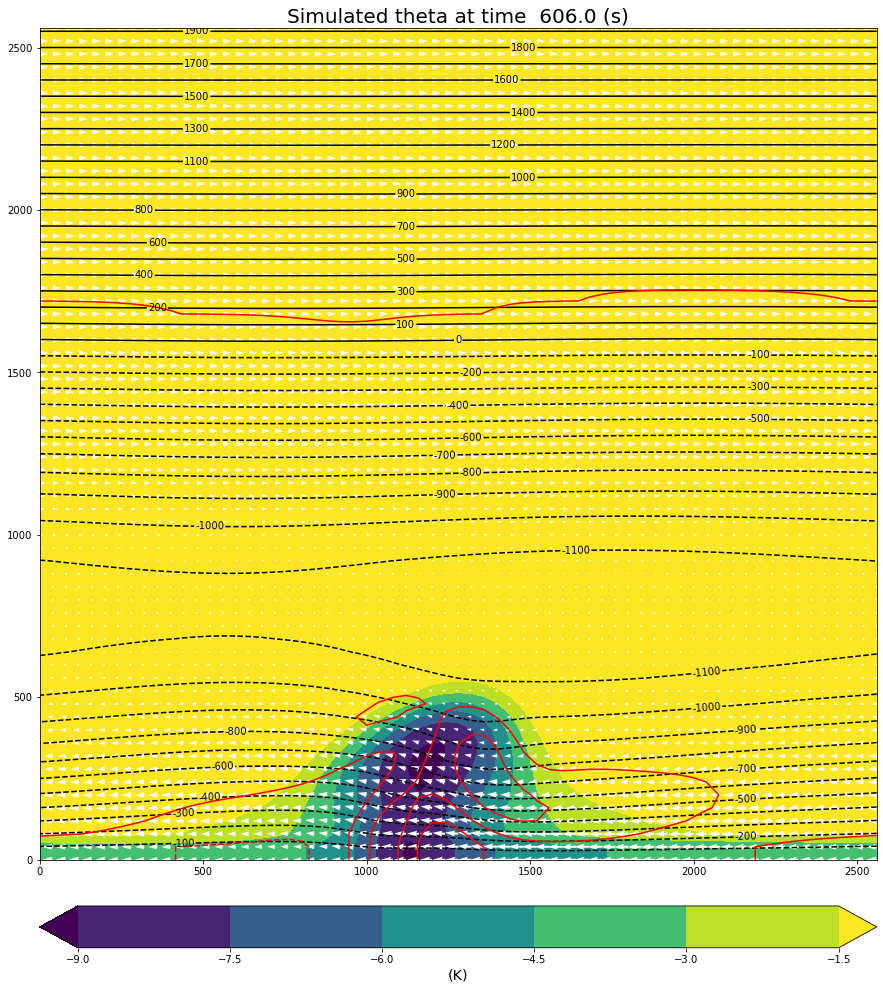

In [ ]:
# Make plots
# First construct figure and axes of plot
fig_ex = plt.figure( figsize=(15, 17) )
ax_ex = fig_ex.add_subplot(111)

outdir=runname+'_pngs'

if outdir and not os.path.exists(outdir): os.mkdir(outdir)

# Time loop to display plots sequentially
for t in np.arange(0,numt,1):
    
    # Clear prior axis data so plots don't stack on top of each other
    ax_ex.clear()
    
    # Note arrays are (row,column...) in python indices. Since i is column and k is
    # row in our model, we need to simply transverse 2-D arrays to align with the 
    # expected plots
    
    # Plot theta
    
    sfmax = np.max( streamf[t,:,:] )
    sfmin = np.min( streamf[t,:,:] )
    
    print("sfmin= {0:6.2f}, sfmax= {1:6.2f} at time {2:6.0f} (s)".format(sfmin, sfmax,t*dt) )
    
    levels = [0.0,0.125,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
#    levels = np.arange(0,3.5,0.5)
    
#    theta_plot = ax_ex.contourf(x_grid,z_grid,theta[t,:,:], levels=levels, extend='both')
    theta_plot = ax_ex.contourf(x_grid,z_grid,theta[t,:,:], extend='both')
    
    # Plot streamfunction (levels are contours, 'w' refers to white contours)
    #streamf_plot = ax_ex.contour(x_grid,z_grid,streamf[t,:,:],\
    #        evels=np.array([-500,-400,-300,-250,-200,-150,-125,-100,-75,-50,-25,\
    #                        25,50,75,100,125,250,200,300,400,500]),colors='red')
    
    levels=np.arange(-500,550,50)
    levels=np.arange(-1500,2100,100)
    
    streamf_plot = ax_ex.contour(x_grid,z_grid,streamf[t,:,:],levels=levels,colors='black')
    ax_ex.clabel(streamf_plot, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    
    levels=np.arange(-0.07,0.08,0.005)
    vort_plot = ax_ex.contour(x_grid,z_grid,vort[t,:,:],levels=levels,colors='red')
#    vort_plot1 = ax_ex.contour(x_grid,z_grid,vort1[t,:,:],levels=levels,colors='blue')
    
    # Plot wind vectors at windintv intervals (python slices arrays as [start:stop:interval])
    windintv = 1 # Plot interval for wind vectors
    vector_plot = ax_ex.quiver(x_grid[::windintv],z_grid[::windintv],\
                               u[t,::windintv,::windintv],w[t,::windintv,::windintv], color='white')

    time = t*dt
    plt.title('Simulated theta at time {0:6.1f} (s)'.format(time),fontsize=20 )
    
    if t == 0:
       cb1 = fig_ex.colorbar(theta_plot, ax=ax_ex, location='bottom', shrink=1.0, fraction=0.05, pad=0.05)
       cb1.set_label('(K)', size='x-large')

    # Display plots
    clear_output(wait=True)
    display(fig_ex)
    
    if outdir: 
        timestamp = round(time,2)
        pngname = outdir+'/'+runname+'%06d.png' % round(timestamp) 
#        print( pngname )
        plt.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait',bbox_inches = 'tight')
    
clear_output()

In [18]:
from janim import makeanim
import glob

pngs = glob.glob(outdir+'/*.png') # the * matches anything
pngs.sort()
makeanim(pngs,outfile=runname+'.html',sortOrder=True,
         ctlOnSide=True,titlestring="Animation of 2D Thermal Bubble Convection")

In [17]:
ds = xr.open_dataset(runname+'.nc')

ds

<xarray.Dataset>
Dimensions:  (x: 65, z: 65, time: 401)
Coordinates:
  * x        (x) float32 0.0 40.0 80.0 120.0 ... 2.48e+03 2.52e+03 2.56e+03
  * z        (z) float32 0.0 40.0 80.0 120.0 ... 2.48e+03 2.52e+03 2.56e+03
  * time     (time) float32 0.0 2.0 4.0 6.0 8.0 ... 794.0 796.0 798.0 800.0
Data variables:
    u        (time, z, x) float32 ...
    w        (time, z, x) float32 ...
    vort     (time, z, x) float32 ...
    theta    (time, z, x) float32 ...
    streamf  (time, z, x) float32 ...